
This notebook implements a ResNet-based 2D convolutional neural network for hyperspectral image classification. 

The workflow in this file includes:

- Setting up the Python environment and necessary imports, including PyTorch and supporting libraries for handling data, training models, and computing metrics.
- Defining paths where input artifacts, figures, and experiment runs are stored.
- Seeding random number generators to ensure reproducibility.
- Selecting the computational device (CPU or GPU) automatically and reporting it.
- Loading hyperspectral image data along with corresponding training, validation, and test masks.
- Determining image dimensions as well as the number of spectral bands (B) and classes present in the dataset.

The rest of the notebook continues with model definition, training, and evaluation.


In [1]:
from pathlib import Path                                                 # import from pathlibimport time                                                              # import time libraryimport numpy as np                                                       # import numpy libraryimport matplotlib.pyplot as plt                                          # import matplotlib.pyplot library# empty lineimport torch                                                             # import torch libraryimport torch.nn as nn                                                    # import torch.nn libraryimport torch.optim as optim                                              # import torch.optim libraryfrom torch.utils.data import Dataset, DataLoader, WeightedRandomSampler  # import from torch.utils.data# empty linefrom sklearn.metrics import (                                            # import from sklearn.metrics    confusion_matrix,    accuracy_score,    precision_recall_fscore_support,    cohen_kappa_score,    classification_report,)# empty linenp.random.seed(42)torch.manual_seed(42)# empty lineARTIFACTS = Path("outputs/artifacts_ip")                                 # define path for ARTIFACTSFIGS = Path("outputs/figs")                                              # define path for FIGSRUNS = Path("outputs/runs_resnet2d")                                     # define path for RUNSFIGS.mkdir(parents=True, exist_ok=True)                                  # create directory FIGS.mkdir(parentsRUNS.mkdir(parents=True, exist_ok=True)                                  # create directory RUNS.mkdir(parents# empty lineDEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")    # set computation device (GPU/CPU)print("Device", DEVICE)

Device cuda


In [2]:
cube = np.load(ARTIFACTS / "cube_clean_norm.npy")           # H W Blabels = np.load(ARTIFACTS / "labels.npy")                  # H W with one based ids and zero for backgroundmask_train = np.load(ARTIFACTS / "mask_train.npy")          # H Wmask_val   = np.load(ARTIFACTS / "mask_val.npy")            # H Wmask_test  = np.load(ARTIFACTS / "mask_test.npy")           # H W# empty lineH, W, B = cube.shape                                        # assign value to H, W, Bnum_classes = int(labels.max())                             # assign value to num_classesprint("Cube", cube.shape, "Classes", num_classes)

Cube (145, 145, 200) Classes 16


In [3]:
class PatchDataset2D(Dataset):                                             # define class PatchDataset2D    def __init__(self, cube_c_last: np.ndarray, lab_map: np.ndarray, mask_map: np.ndarray, patch: int):  # define function __init__        assert patch % 2 == 1, "patch must be odd"                         # assign value to assert patch % 2        self.patch = patch                                                 # assign value to self.patch        self.rad = patch // 2                                              # assign value to self.rad        self.H, self.W, self.C = cube_c_last.shape                         # assign value to self.H, self.W, self.C        self.img = np.pad(                                                 # assign value to self.img            cube_c_last.astype(np.float32),            ((self.rad, self.rad), (self.rad, self.rad), (0, 0)),            mode="reflect"                                                 # assign value to mode        )        yy, xx = np.where(mask_map & (lab_map > 0))                        # assign value to yy, xx        self.centers = np.stack([yy, xx], axis=1)                          # assign value to self.centers        self.labels = lab_map[mask_map & (lab_map > 0)].astype(np.int64) - 1  # assign value to self.labels# empty line    def __len__(self):                                                     # define function __len__        return self.centers.shape[0]                                       # return value from function# empty line    def __getitem__(self, i):                                              # define function __getitem__        y, x = self.centers[i]                                             # assign value to y, x        yp, xp = y + self.rad, x + self.rad                                # assign value to yp, xp        patch = self.img[yp - self.rad: yp + self.rad + 1,                 # assign value to patch                         xp - self.rad: xp + self.rad + 1, :]              # P P C        patch = np.transpose(patch, (2, 0, 1))                             # C P P        return torch.from_numpy(patch), torch.tensor(self.labels[i], dtype=torch.long)  # assign value to return torch.from_numpy(patch), torch.tensor(self.labels[i], dtype# empty linePATCH = 15                                                                 # assign value to PATCHds_train = PatchDataset2D(cube, labels, mask_train, patch=PATCH)           # assign value to ds_trainds_val   = PatchDataset2D(cube, labels, mask_val,   patch=PATCH)           # assign value to ds_valds_test  = PatchDataset2D(cube, labels, mask_test,  patch=PATCH)           # assign value to ds_test# empty lineprint("Train", len(ds_train), "Val", len(ds_val), "Test", len(ds_test), "Bands", B)

Train 7686 Val 513 Test 2050 Bands 200


In [4]:
BATCH = 64                                                                 # assign value to BATCH# empty liney_tr = ds_train.labels                                                     # assign value to y_trcounts = np.bincount(y_tr, minlength=num_classes).astype(np.float32)       # assign value to countsclass_w = 1.0 / np.maximum(counts, 1.0)                                    # assign value to class_wsample_w = class_w[y_tr]                                                   # assign value to sample_w# empty linesampler = WeightedRandomSampler(                                           # assign value to sampler    weights=torch.from_numpy(sample_w),                                    # assign value to weights    num_samples=len(sample_w),                                             # assign value to num_samples    replacement=True,                                                      # assign value to replacement)# empty linedl_train = DataLoader(ds_train, batch_size=BATCH, sampler=sampler, drop_last=False, num_workers=0)  # assign value to dl_traindl_val   = DataLoader(ds_val,   batch_size=BATCH, shuffle=False, drop_last=False, num_workers=0)  # assign value to dl_valdl_test  = DataLoader(ds_test,  batch_size=BATCH, shuffle=False, drop_last=False, num_workers=0)  # assign value to dl_test# empty lineprint("Batches  train", len(dl_train), "val", len(dl_val), "test", len(dl_test))

Batches  train 121 val 9 test 33


In [5]:
def conv3x3(in_ch, out_ch, stride=1):                                      # assign value to def conv3x3(in_ch, out_ch, stride    return nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1, bias=False)  # assign value to return nn.Conv2d(in_ch, out_ch, kernel_size# empty lineclass BasicBlock(nn.Module):                                               # define class BasicBlock    expansion = 1                                                          # assign value to expansion    def __init__(self, in_ch, out_ch, stride=1):                           # assign value to def __init__(self, in_ch, out_ch, stride        super().__init__()        self.conv1 = conv3x3(in_ch, out_ch, stride)                        # assign value to self.conv1        self.bn1 = nn.BatchNorm2d(out_ch)                                  # assign value to self.bn1        self.relu = nn.ReLU(inplace=True)                                  # assign value to self.relu        self.conv2 = conv3x3(out_ch, out_ch, 1)                            # assign value to self.conv2        self.bn2 = nn.BatchNorm2d(out_ch)                                  # assign value to self.bn2# empty line        self.down = None                                                   # assign value to self.down        if stride != 1 or in_ch != out_ch:                                 # assign value to if stride !            self.down = nn.Sequential(                                     # assign value to self.down                nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=stride, bias=False),  # assign value to nn.Conv2d(in_ch, out_ch, kernel_size                nn.BatchNorm2d(out_ch),            )# empty line    def forward(self, x):                                                  # define function forward        identity = x                                                       # assign value to identity        out = self.relu(self.bn1(self.conv1(x)))                           # assign value to out        out = self.bn2(self.conv2(out))                                    # assign value to out        if self.down is not None:                                          # conditional statement            identity = self.down(x)                                        # assign value to identity        out = self.relu(out + identity)                                    # assign value to out        return out                                                         # return value from function

In [6]:
class SmallResNet(nn.Module):                                              # define class SmallResNet    """    A light ResNet for small patches    Stem uses 3 by 3 conv    No initial max pool to keep detail    """    def __init__(self, in_ch: int, num_classes: int, reduce_to: int | None = 32):  # assign value to def __init__(self, in_ch: int, num_classes: int, reduce_to: int | None        super().__init__()        c_in = in_ch                                                       # assign value to c_in                                                                           # optional one by one conv to reduce channels when B is large        if reduce_to is not None:                                          # conditional statement            self.reduce = nn.Sequential(                                   # assign value to self.reduce                nn.Conv2d(c_in, reduce_to, kernel_size=1, bias=False),     # assign value to nn.Conv2d(c_in, reduce_to, kernel_size                nn.BatchNorm2d(reduce_to),                nn.ReLU(inplace=True),                                     # assign value to nn.ReLU(inplace            )            c_in = reduce_to                                               # assign value to c_in        else:                                                              # conditional statement            self.reduce = nn.Identity()                                    # assign value to self.reduce# empty line        self.stem = nn.Sequential(                                         # assign value to self.stem            nn.Conv2d(c_in, 32, kernel_size=3, stride=1, padding=1, bias=False),  # assign value to nn.Conv2d(c_in, 32, kernel_size            nn.BatchNorm2d(32),            nn.ReLU(inplace=True),                                         # assign value to nn.ReLU(inplace        )                                                                           # three stages with downsample at the start of stage two and three        self.layer1 = nn.Sequential(                                       # assign value to self.layer1            BasicBlock(32, 32, stride=1),                                  # assign value to BasicBlock(32, 32, stride            BasicBlock(32, 32, stride=1),                                  # assign value to BasicBlock(32, 32, stride        )        self.layer2 = nn.Sequential(                                       # assign value to self.layer2            BasicBlock(32, 64, stride=2),                                  # assign value to BasicBlock(32, 64, stride            BasicBlock(64, 64, stride=1),                                  # assign value to BasicBlock(64, 64, stride        )        self.layer3 = nn.Sequential(                                       # assign value to self.layer3            BasicBlock(64, 128, stride=2),                                 # assign value to BasicBlock(64, 128, stride            BasicBlock(128, 128, stride=1),                                # assign value to BasicBlock(128, 128, stride        )        self.pool = nn.AdaptiveAvgPool2d(1)                                # assign value to self.pool        self.head = nn.Linear(128, num_classes)                            # assign value to self.head# empty line    def forward(self, x):                                                  # define function forward        x = self.reduce(x)                                                 # assign value to x        x = self.stem(x)                                                   # assign value to x        x = self.layer1(x)                                                 # assign value to x        x = self.layer2(x)                                                 # assign value to x        x = self.layer3(x)                                                 # assign value to x        x = self.pool(x)                                                   # assign value to x        x = torch.flatten(x, 1)                                            # assign value to x        return self.head(x)                                                # return value from function# empty lineREDUCE = 32                                                                # set None to use all bands through the stemmodel = SmallResNet(in_ch=B, num_classes=num_classes, reduce_to=REDUCE).to(DEVICE)  # assign value to modelprint("Params", sum(p.numel() for p in model.parameters()))

Params 712208


In [7]:
criterion = nn.CrossEntropyLoss()                                          # assign value to criterionoptimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=5e-5)    # assign value to optimizerscheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=40)      # assign value to scheduler# empty linedef metrics_from_logits(logits: torch.Tensor, targets: torch.Tensor, C: int) -> dict:  # define function metrics_from_logits    preds = logits.argmax(1).cpu().numpy()                                 # assign value to preds    true = targets.cpu().numpy()                                           # assign value to true    acc = accuracy_score(true, preds)                                      # assign value to acc    prec, rec, f1, _ = precision_recall_fscore_support(true, preds, labels=np.arange(C), average="macro", zero_division=0)  # assign value to prec, rec, f1, _    kap = cohen_kappa_score(true, preds)                                   # assign value to kap    cm = confusion_matrix(true, preds, labels=np.arange(C))                # assign value to cm    return {"acc": acc, "prec": prec, "rec": rec, "f1": f1, "kappa": kap, "cm": cm}  # return value from function

In [8]:
EPOCHS = 120                                                               # assign value to EPOCHSPATIENCE = 15                                                              # assign value to PATIENCEbest_score = float("-inf")                                                 # assign value to best_scorebest_state = None                                                          # assign value to best_statebest_epoch = 0                                                             # assign value to best_epochbad_epochs = 0                                                             # assign value to bad_epochshistory = []                                                               # assign value to history# empty linet0 = time.time()                                                           # assign value to t0# empty linefor ep in range(1, EPOCHS + 1):                                            # loop iteration    model.train()    run, n = 0.0, 0                                                        # assign value to run, n    for xb, yb in dl_train:                                                # loop iteration        xb = xb.to(DEVICE)                                                 # assign value to xb        yb = yb.to(DEVICE)                                                 # assign value to yb        optimizer.zero_grad(set_to_none=True)                              # assign value to optimizer.zero_grad(set_to_none        lg = model(xb)                                                     # assign value to lg        ls = criterion(lg, yb)                                             # assign value to ls        ls.backward()        optimizer.step()        run += ls.item() * xb.size(0)                                      # assign value to run +        n += xb.size(0)                                                    # assign value to n +    tr_loss = run / max(1, n)                                              # assign value to tr_loss# empty line    model.eval()    with torch.no_grad():        all_lg, all_y = [], []                                             # assign value to all_lg, all_y        for xb, yb in dl_val:                                              # loop iteration            all_lg.append(model(xb.to(DEVICE)))            all_y.append(yb.to(DEVICE))        lg_cat = torch.cat(all_lg, 0)                                      # assign value to lg_cat        y_cat  = torch.cat(all_y, 0)                                       # assign value to y_cat        v_metrics = metrics_from_logits(lg_cat, y_cat, num_classes)        # assign value to v_metrics    scheduler.step()# empty line    history.append({"epoch": ep, "train_loss": tr_loss, "val_acc": v_metrics["acc"], "val_f1": v_metrics["f1"]})    print(f"Epoch {ep:03d}  tl {tr_loss:.4f}  va {v_metrics['acc']:.4f}  vf {v_metrics['f1']:.4f}")# empty line    if v_metrics["f1"] > best_score:                                       # conditional statement        best_score = v_metrics["f1"]                                       # assign value to best_score        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}  # assign value to best_state        best_epoch = ep                                                    # assign value to best_epoch        bad_epochs = 0                                                     # assign value to bad_epochs    else:                                                                  # conditional statement        bad_epochs += 1                                                    # assign value to bad_epochs +        if bad_epochs >= PATIENCE:                                         # assign value to if bad_epochs >            print("Early stop at epoch", ep, "best epoch", best_epoch, "best F1", round(best_score, 4))            break# empty linetrain_time = time.time() - t0                                              # assign value to train_timeprint("Train time seconds", round(train_time, 2))# empty lineckpt_path = RUNS / "resnet2d_fullbands_best.pth"                           # assign value to ckpt_pathtorch.save({"state_dict": best_state, "num_classes": num_classes, "PATCH": PATCH, "B": B, "REDUCE": REDUCE}, ckpt_path)print("Saved", ckpt_path.as_posix())

Epoch 001  tl 0.5904  va 0.8207  vf 0.8670
Epoch 002  tl 0.2479  va 0.8421  vf 0.9097
Epoch 003  tl 0.1136  va 0.9805  vf 0.9850
Epoch 004  tl 0.1223  va 0.8889  vf 0.9352
Epoch 005  tl 0.1030  va 0.9298  vf 0.9263
Epoch 006  tl 0.0658  va 0.9864  vf 0.9904
Epoch 007  tl 0.0863  va 0.8635  vf 0.9382
Epoch 008  tl 0.0903  va 0.9844  vf 0.9856
Epoch 009  tl 0.0761  va 0.9825  vf 0.9905
Epoch 010  tl 0.0248  va 0.9961  vf 0.9916
Epoch 011  tl 0.0145  va 0.9747  vf 0.9713
Epoch 012  tl 0.0421  va 0.9942  vf 0.9941
Epoch 013  tl 0.0557  va 0.9961  vf 0.9982
Epoch 014  tl 0.0291  va 0.9493  vf 0.9624
Epoch 015  tl 0.0586  va 1.0000  vf 1.0000
Epoch 016  tl 0.0147  va 1.0000  vf 1.0000
Epoch 017  tl 0.0140  va 0.9922  vf 0.9934
Epoch 018  tl 0.0085  va 0.9981  vf 0.9967
Epoch 019  tl 0.0299  va 0.9981  vf 0.9993
Epoch 020  tl 0.0145  va 0.9981  vf 0.9983
Epoch 021  tl 0.0187  va 0.9981  vf 0.9993
Epoch 022  tl 0.0101  va 1.0000  vf 1.0000
Epoch 023  tl 0.0063  va 0.9942  vf 0.9943
Epoch 024  

Val accuracy 1.0
Val kappa 1.0
Val f1 macro 1.0


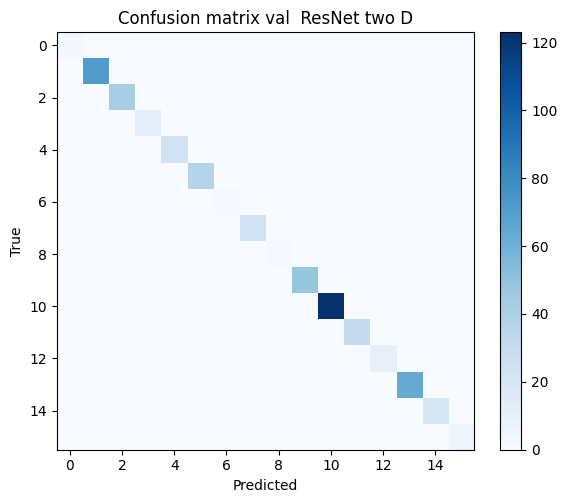

In [9]:
model.load_state_dict(best_state)model.to(DEVICE).eval()# empty linewith torch.no_grad():    v_logits, v_targets = [], []                                # assign value to v_logits, v_targets    for xb, yb in dl_val:                                       # loop iteration        v_logits.append(model(xb.to(DEVICE)))        v_targets.append(yb.to(DEVICE))    v_logits = torch.cat(v_logits, 0)                           # assign value to v_logits    v_targets = torch.cat(v_targets, 0)                         # assign value to v_targets    vm = metrics_from_logits(v_logits, v_targets, num_classes)  # assign value to vm# empty lineprint("Val accuracy", vm["acc"])print("Val kappa", vm["kappa"])print("Val f1 macro", vm["f1"])# empty lineplt.figure(figsize=(6, 5))                                      # assign value to plt.figure(figsizeplt.imshow(vm["cm"], cmap="Blues")                              # assign value to plt.imshow(vm["cm"], cmapplt.title("Confusion matrix val  ResNet two D")plt.xlabel("Predicted")plt.ylabel("True")plt.colorbar()plt.tight_layout()plt.savefig(FIGS / "resnet2d_confusion_val.png", dpi=150)       # assign value to plt.savefig(FIGS / "resnet2d_confusion_val.png", dpiplt.show()

Test accuracy 0.9897560975609756
Test kappa 0.9883359853951906
Test f1 macro 0.9937432456481471


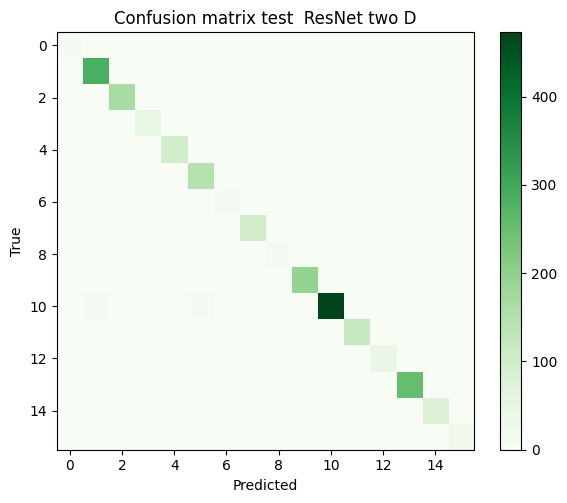


Classification report on test
              precision    recall  f1-score   support

     class_1     1.0000    1.0000    1.0000         9
     class_2     0.9628    0.9965    0.9794       286
     class_3     0.9940    1.0000    0.9970       166
     class_4     1.0000    1.0000    1.0000        47
     class_5     1.0000    1.0000    1.0000        97
     class_6     0.9733    1.0000    0.9865       146
     class_7     1.0000    1.0000    1.0000         5
     class_8     1.0000    1.0000    1.0000        96
     class_9     1.0000    1.0000    1.0000         4
    class_10     0.9847    0.9948    0.9897       194
    class_11     1.0000    0.9633    0.9813       491
    class_12     0.9916    0.9916    0.9916       119
    class_13     1.0000    1.0000    1.0000        41
    class_14     1.0000    1.0000    1.0000       253
    class_15     1.0000    1.0000    1.0000        77
    class_16     0.9500    1.0000    0.9744        19

    accuracy                         0.9898      

In [10]:
with torch.no_grad():    t_logits, t_targets = [], []                                           # assign value to t_logits, t_targets    for xb, yb in dl_test:                                                 # loop iteration        t_logits.append(model(xb.to(DEVICE)))        t_targets.append(yb.to(DEVICE))    t_logits = torch.cat(t_logits, 0)                                      # assign value to t_logits    t_targets = torch.cat(t_targets, 0)                                    # assign value to t_targets    tm = metrics_from_logits(t_logits, t_targets, num_classes)             # assign value to tm# empty lineprint("Test accuracy", tm["acc"])print("Test kappa", tm["kappa"])print("Test f1 macro", tm["f1"])# empty lineplt.figure(figsize=(6, 5))                                                 # assign value to plt.figure(figsizeplt.imshow(tm["cm"], cmap="Greens")                                        # assign value to plt.imshow(tm["cm"], cmapplt.title("Confusion matrix test  ResNet two D")plt.xlabel("Predicted")plt.ylabel("True")plt.colorbar()plt.tight_layout()plt.savefig(FIGS / "resnet2d_confusion_test.png", dpi=150)                 # assign value to plt.savefig(FIGS / "resnet2d_confusion_test.png", dpiplt.show()# empty linenames = [f"class_{i}" for i in range(1, num_classes + 1)]                  # assign value to namesprint("\nClassification report on test")print(classification_report(t_targets.cpu().numpy(), t_logits.argmax(1).cpu().numpy(),                            target_names=names, digits=4, zero_division=0))  # assign value to target_names

In [11]:
from sklearn.metrics import (                                              # import from sklearn.metrics    accuracy_score,    cohen_kappa_score,    precision_recall_fscore_support,    classification_report,    confusion_matrix,)# empty line                                                                           # convert tensors to numpyy_true = t_targets.cpu().numpy()                                           # assign value to y_truey_pred = t_logits.argmax(1).cpu().numpy()                                  # assign value to y_pred# empty line                                                                           # global metricsoa = accuracy_score(y_true, y_pred)                                        # assign value to oakappa = cohen_kappa_score(y_true, y_pred)                                  # assign value to kappa# empty lineprec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(      # assign value to prec_macro, rec_macro, f1_macro, _    y_true, y_pred, average="macro", zero_division=0                       # assign value to y_true, y_pred, average)prec_weighted, rec_weighted, f1_weighted, _ = precision_recall_fscore_support(  # assign value to prec_weighted, rec_weighted, f1_weighted, _    y_true, y_pred, average="weighted", zero_division=0                    # assign value to y_true, y_pred, average)# empty line                                                                           # per class metricsprec_class, rec_class, f1_class, support_class = precision_recall_fscore_support(  # assign value to prec_class, rec_class, f1_class, support_class    y_true, y_pred, average=None, zero_division=0                          # assign value to y_true, y_pred, average)# empty lineprint("Overall accuracy:", oa)print("Cohen kappa:", kappa)print("Macro precision:", prec_macro)print("Macro recall:", rec_macro)print("Macro f1:", f1_macro)print("Weighted precision:", prec_weighted)print("Weighted recall:", rec_weighted)print("Weighted f1:", f1_weighted)# empty lineprint("\nPer class metrics")for i, (p, r, f1, s) in enumerate(                                         # loop iteration    zip(prec_class, rec_class, f1_class, support_class), start=1           # assign value to zip(prec_class, rec_class, f1_class, support_class), start):    print(        f"Class {i:02d}: "        f"precision={p:.4f}, recall={r:.4f}, f1={f1:.4f}, support={s}"     # assign value to f"precision    )# empty lineprint("\nFull classification report")print(    classification_report(        y_true,        y_pred,        target_names=[f"class_{i}" for i in range(1, num_classes + 1)],    # assign value to target_names        digits=4,                                                          # assign value to digits        zero_division=0,                                                   # assign value to zero_division    ))# empty line

Overall accuracy: 0.9897560975609756
Cohen kappa: 0.9883359853951906
Macro precision: 0.9910296039640973
Macro recall: 0.9966428511364559
Macro f1: 0.9937432456481471
Weighted precision: 0.9900316529547017
Weighted recall: 0.9897560975609756
Weighted f1: 0.9897495846061364

Per class metrics
Class 01: precision=1.0000, recall=1.0000, f1=1.0000, support=9
Class 02: precision=0.9628, recall=0.9965, f1=0.9794, support=286
Class 03: precision=0.9940, recall=1.0000, f1=0.9970, support=166
Class 04: precision=1.0000, recall=1.0000, f1=1.0000, support=47
Class 05: precision=1.0000, recall=1.0000, f1=1.0000, support=97
Class 06: precision=0.9733, recall=1.0000, f1=0.9865, support=146
Class 07: precision=1.0000, recall=1.0000, f1=1.0000, support=5
Class 08: precision=1.0000, recall=1.0000, f1=1.0000, support=96
Class 09: precision=1.0000, recall=1.0000, f1=1.0000, support=4
Class 10: precision=0.9847, recall=0.9948, f1=0.9897, support=194
Class 11: precision=1.0000, recall=0.9633, f1=0.9813, su

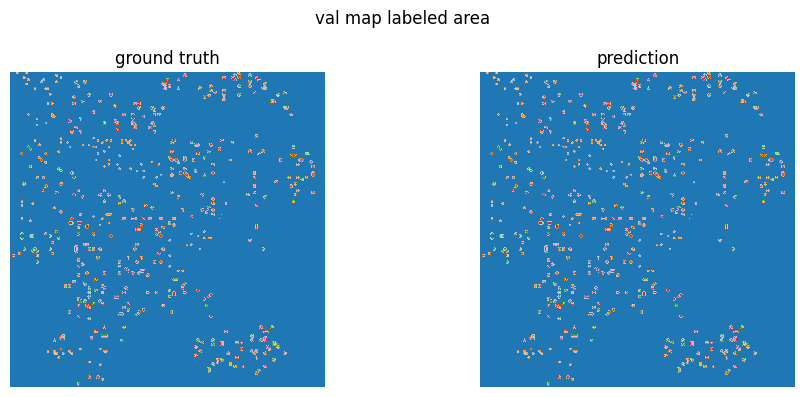

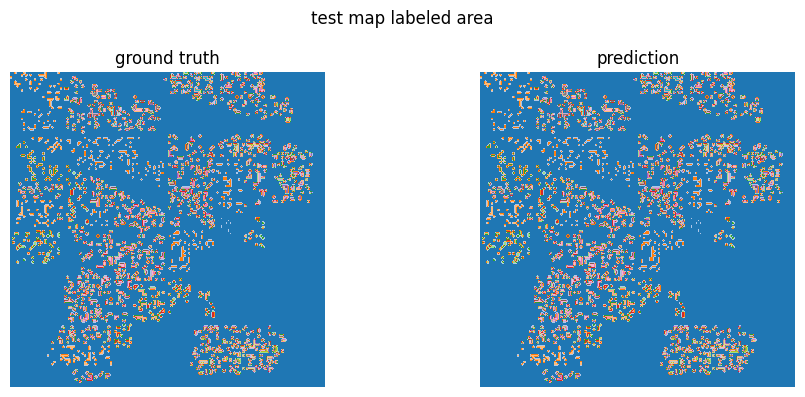

In [12]:
def predict_on_mask(model, ds: PatchDataset2D, mask_map: np.ndarray, num_classes: int) -> np.ndarray:  # define function predict_on_mask    model.eval()    pred_map = np.zeros_like(labels, dtype=np.int64)                       # assign value to pred_map    loader = DataLoader(ds, batch_size=256, shuffle=False)                 # assign value to loader    idx = 0                                                                # assign value to idx    with torch.no_grad():        for xb, _ in loader:                                               # loop iteration            lg = model(xb.to(DEVICE))                                      # assign value to lg            pb = lg.argmax(1).cpu().numpy() + 1                            # assign value to pb            n = pb.shape[0]                                                # assign value to n            for j in range(n):                                             # loop iteration                y, x = ds.centers[idx + j]                                 # assign value to y, x                pred_map[y, x] = pb[j]                                     # assign value to pred_map[y, x]            idx += n                                                       # assign value to idx +    pred_map[~mask_map] = 0                                                # assign value to pred_map[~mask_map]    return pred_map                                                        # return value from function# empty linepred_val_map = predict_on_mask(model, ds_val, mask_val & (labels > 0), num_classes)  # assign value to pred_val_mappred_test_map = predict_on_mask(model, ds_test, mask_test & (labels > 0), num_classes)  # assign value to pred_test_map# empty linedef show_maps(gt, pr, title, fname):                                       # define function show_maps    plt.figure(figsize=(10, 4))                                            # assign value to plt.figure(figsize    plt.subplot(1, 2, 1); plt.imshow(gt, cmap="tab20"); plt.title("ground truth"); plt.axis("off")  # assign value to plt.subplot(1, 2, 1); plt.imshow(gt, cmap    plt.subplot(1, 2, 2); plt.imshow(pr, cmap="tab20"); plt.title("prediction"); plt.axis("off")  # assign value to plt.subplot(1, 2, 2); plt.imshow(pr, cmap    plt.suptitle(title); plt.tight_layout(); plt.savefig(FIGS / fname, dpi=150); plt.show()  # assign value to plt.suptitle(title); plt.tight_layout(); plt.savefig(FIGS / fname, dpi# empty lineshow_maps(np.where(mask_val, labels, 0), pred_val_map, "val map labeled area", "resnet2d_val_maps.png")show_maps(np.where(mask_test, labels, 0), pred_test_map, "test map labeled area", "resnet2d_test_maps.png")